In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import train_test_split

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing

# encoding
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from category_encoders import OrdinalEncoder
from category_encoders import BinaryEncoder 

# scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Cross Validation
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_validate

# model Classification
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier         # Untuk Random Forest
from xgboost import XGBClassifier                           # Untuk XGBoost    
import pickle

# scoring classification
from sklearn.metrics import  f1_score, precision_score, recall_score, precision_recall_curve, classification_report, confusion_matrix, RocCurveDisplay

In [3]:
df = pd.read_csv('../DataSet/bank-additional-full_cleaned.csv',sep=',')

In [4]:
df.duplicated().sum()

np.int64(10)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df['y'] = df['y'].map({'no': 0, 'yes': 1}).astype(int)

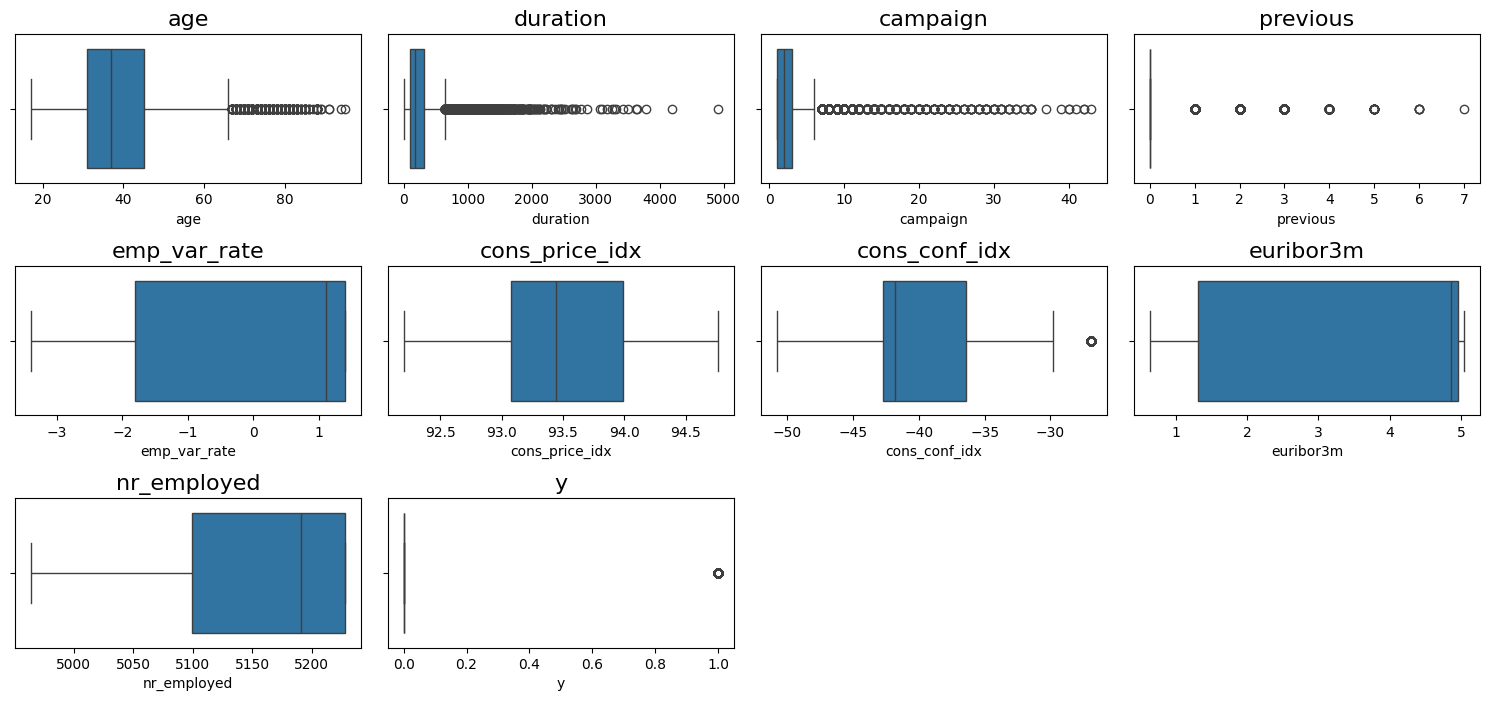

In [7]:
# Outlier Check
num_feature = df.describe().columns
plt.figure(figsize=(15, 9), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(4,4, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

## **Data Preprocessing**

In [8]:
ordinal_mapping = [
    {
        'col': 'education',
        'mapping': {'illiterate': 1, 'basic.4y': 2, 'basic.6y': 3, 'basic.9y': 4, 'high.school':5, 'professional.course':6, 'university.degree': 7}
    }
]

This process aims to perform ordinal encoding on the education feature by assigning numerical values based on the level of education. This allows the machine learning model to understand the hierarchical relationship between categories — for example, that university.degree represents a higher level than high.school.

Encoding Feature: 
- **Robust Scaler :**  `age`,`campaign`, `emp_var_rate`, `cons_price_idx`, `cons_conf_idx`, `euribor3m`, `nr_employed`,`duration`
- **Onehot Encoder :**  `marital`, `default`, `housing`, `loan`, `contact`, `poutcome`.
- **Binary Encoder:**  `job`, `month`, `day_of_week`
- **Ordinal Encoder:**  `education`,

In [9]:
transformer = ColumnTransformer([
    # Ordinal encoding
    ("ordinal", OrdinalEncoder(cols=["education"], mapping=ordinal_mapping), ["education"]),

    # One-hot encoding
    ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
     [ "marital", "default", "housing", "loan", "contact", "poutcome"]),

    # binary encoding
    ("binary", BinaryEncoder(), 
     ["job", "month", "day_of_week"]),

    # Scaling
    ("scaler", RobustScaler(), ["age","campaign", "emp_var_rate", "cons_price_idx", 
                                "cons_conf_idx", "euribor3m", "nr_employed","duration"])
], remainder='passthrough', verbose_feature_names_out=False)

In [10]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(cols=['education'],
                                                mapping=[{'col': 'education',
                                                          'data_type': dtype('O'),
                                                          'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
professional.course    6
university.degree      7
dtype: int64}]),
                                 ['education']),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['marital', 'default', 'housing', 'loan',
                                  'contact', 'poutcome']),
                                ('binary', BinaryEncoder(),
                                 ['job', 'month', 'day_of_week']),
                                ('scaler', RobustScaler(),
                                 ['age', 'campaign', 'emp_var_rate',
                                  'cons_price_idx', 'cons_conf_idx',
                                  'euribor3m', 'nr_employed', 'duration'])],
                  verbose_feature_names_out=False)

## **Modelling and Evaluation**

In [11]:
# Define X and y
X = df.drop(columns=['y'])
y = df['y']

In [12]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split( 
    X, 
    y, 
    test_size=0.2,  
    random_state=42, 
    stratify=y
)

In [13]:
# Check target proportion
df['y'].value_counts()/len(df['y']) * 100

y
0    87.341689
1    12.658311
Name: count, dtype: float64

In [14]:
sampling_strategies = {
    'none': None,
    'smote': SMOTE(random_state=42),
    'under_sampling': RandomUnderSampler(random_state=42),
    'smote_tomek': SMOTETomek(random_state=42)
}

### **Cross Validation and Check Perfomance to Data Test**
